# Vacunaciones por municipio

> La dimensión geográfica de la campaña de vacunación contra el covid-19. Municipios con más vacunados tienen mayor acceso a servicios básicos y menor mortalidad por covid-19. 

In [532]:
import pandas as pd
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
import geopandas as gpd
import datetime as dt
import locale
import itertools
import numpy as np
plt.style.use('publish/estilo.mplstyle')
locale.setlocale(locale.LC_TIME, "es_US.UTF8");

## Niveles de inmunización

Diego Acevedo Quintanilla [publica datos](https://github.com/dquintani/vacunacion-municipios-bo) del porcentaje de aplicación de primeras y segundas dosis en poblaciones municipales desde fines de Octubre.

In [534]:
def get_codines(data, mundict):
    municipios = pd.read_csv(mundict)
    df = pd.read_csv(data, index_col=0)
    df['dm'] = df.apply(lambda x: '{} - {}'.format(x['departamento'].lower().strip(), x['municipio'].lower().strip()), axis=1)
    df['cod_ine'] = df.dm.map(municipios.set_index('dm').cod_ine.to_dict())
    df['vacunacion'] = df['vacunacion'].apply(lambda x: float(x.replace('%', '')) / 100)
    return df.drop(columns=['dm'])

vacunacion = get_codines('data/vacunacion_municipios_bo.csv', 'data/mundict.csv')
v1, v2 = [vacunacion[vacunacion.dosis == dosis].groupby(['fecha', 'cod_ine']).vacunacion.first().reset_index().pivot_table(index='cod_ine', columns='fecha', values='vacunacion').sort_values('2021-11-27', ascending=False) for dosis in [1,2]]
vd = v1 - v2
gdf = gpd.read_file('data/mapa_municipios.geojson').set_index('cod_ine')

Qué poblaciones municipales están mejor inmunizadas?

In [545]:
def mapcompare(dataframe, col_1, col_2, title, lenbins=9, datecols=True, text=None):
    
    lincolor = '#88888f'
    bins = pd.qcut(dataframe.stack(), q=lenbins, retbins=True)[1]

    f, axs = plt.subplots(1,2,figsize=(15,8))
    for i, (ax, date) in enumerate(zip(axs, [col_1, col_2])):
        if datecols:
            date_format = dt.datetime.strptime(date, '%Y-%m-%d')
            note_top = date_format.strftime('%B')
            note_bottom = date_format.strftime('%d')
        else:
            note_top = text[i][0]
            note_bottom = text[i][1]
            
        pd.concat([dataframe[date], gdf], axis=1).dropna().plot(ax=ax, column=date, cmap='magma', classification_kwds=dict(bins=bins))
        ax.set_axis_off()
        ax.annotate(note_top, xy=(.85,.85), xycoords='axes fraction', fontsize=14, color=lincolor, ha='right', va='bottom')
        ax.annotate(note_bottom, xy=(.85,.84), xycoords='axes fraction', fontsize=25, color=lincolor, ha='right', va='top')

    cax = f.add_axes([0.1, 0.05, 0.80, 0.15])
    cax.set_axis_off()
    norm = colors.Normalize(vmin=bins[0], vmax=bins[-1])
    colorbar = cm.ScalarMappable(norm=norm, cmap='magma')
    cbar = f.colorbar(colorbar, ax=cax, orientation="horizontal", pad=.1, aspect=50)
    cbar.set_label(
        label=title,
        fontsize=14,
        color=lincolor,
        labelpad=18,
    )
    cbar.ax.tick_params(labelsize=10, labelcolor=lincolor)
    cbar.ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    cbar.ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
    cbar.outline.set_linewidth(0)


### Con al menos una dosis

El porcentaje de la población municipal vacunable con al menos una dosis. 

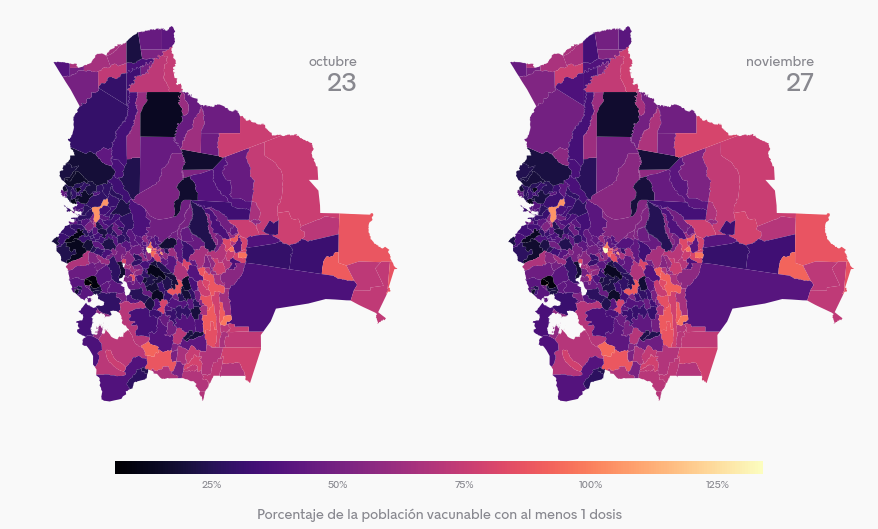

In [271]:
mapcompare(v1, '2021-10-23', '2021-11-27', 'Porcentaje de la población vacunable con al menos 1 dosis')

### Con el esquema completo

El porcentaje de la población municipal vacunable con el esquema completo de vacunación. Municipios con porcentajes más altos y tempranos deberían ser los primeros candidatos para dosis de refuerzo. 

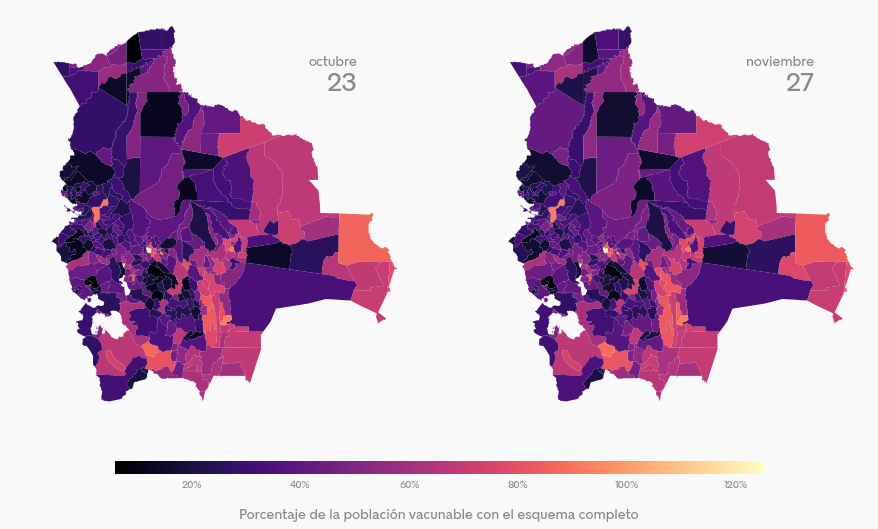

In [272]:
mapcompare(v2, '2021-10-23', '2021-11-27', 'Porcentaje de la población vacunable con el esquema completo')

### Con el esquema incompleto

El porcentaje de la población municipal vacunable que tiene una dosis, pero no el esquema completo. Indica problemas de oferta (baja disponibilidad de dosis) o demanda (la población espera que una dosis sea suficiente)?

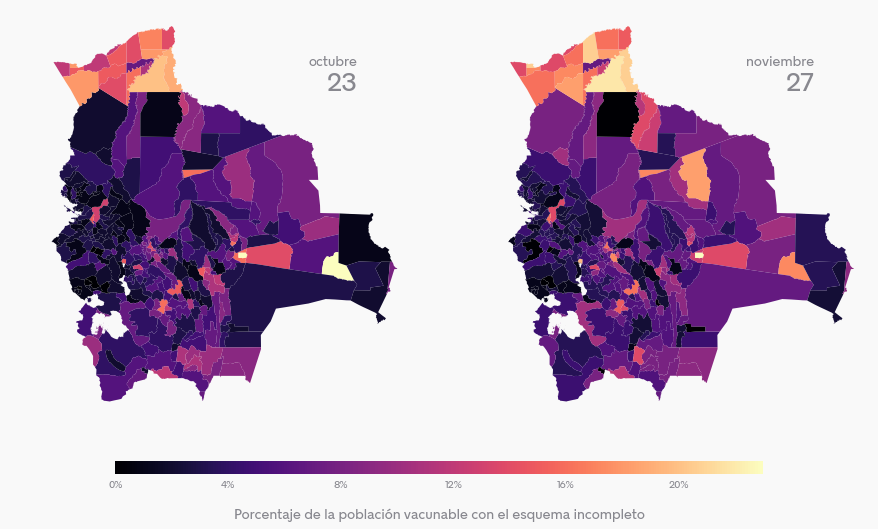

In [536]:
mapcompare(vd, '2021-10-23', '2021-11-27', 'Porcentaje de la población vacunable con el esquema incompleto')

### Recientemente vacunados

Porcentaje de la población municipal vacunable que recibió su dosis entre el 23 de Octubre y 27 de Noviembre. Señala poblaciones con niveles más fuertes de inmunidad frente a una ola cercana de contagios.

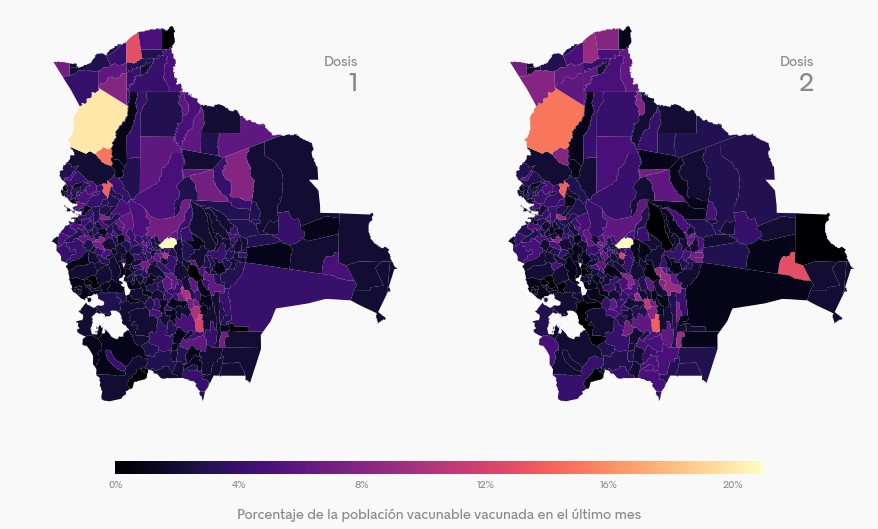

In [546]:
mapcompare(pd.concat([vi['2021-11-27'] - vi['2021-10-23'] for vi in [v1, v2]], axis=1), 0, 1, 'Porcentaje de la población vacunable vacunada en el último mes', datecols=False, text=[['Dosis', '1'], ['Dosis', '2']])

## Las vacunas sirven?

No tenemos datos públicos de municipios en Bolivia para identificar el efecto de la aplicación de vacunas sobre la probabilidad de contagio, enfermedad o fallecimiento. Sin embargo, con los datos actuales es posible sugerir una relación entre la aplicación de vacunas y el porcentaje de pacientes que fallecen. Comparo la mortalidad (número de contagios / número de decesos) por municipio entre el 22 de mayo y el 23 de octubre, con el porcentaje de la población vacunable que recibió el esquema completo al 23 de octubre. Utilizo 5 meses de casos para tener una muestra de tamaño razonable, muestras más pequeñas exhiben una tendencia similar. Además uso la población con el esquema completo porque es más probable que haya estado inmunizada más antes. Si las vacunas sirven, esperaría una relación negativa entre porcentaje de aplicación y mortalidad, poblaciones más inmunizadas exhibirían menos decesos entre sus pacientes de covid-19. Encuentro esta relación:

In [530]:
def covid_por_poblacion(end, start=None, percapita=True):
    if start != None:
        covid = {label: pd.read_csv('data/casos-municipios/{}.csv'.format(date), index_col='cod_ine')[['confirmados', 'recuperados', 'decesos']] for date, label in zip([start, end], ['start', 'end'])}
        covid = covid['end'] - covid['start']
    else:
        covid = pd.read_csv('data/casos-municipios/{}.csv'.format(end), index_col='cod_ine')[['confirmados', 'recuperados', 'decesos']]
    if percapita is True:
        poblacion = pd.read_csv('data/poblacion.csv', index_col='cod_ine')
        covid_pob = pd.concat([covid, poblacion['2021']], axis=1)
        return covid_pob.div(covid_pob['2021'], axis='index').drop(columns=['2021'])
    else:
        return covid

def vacunas_mortalidad(vacunas_dataframe, covid_desde, covid_hasta, vacunas_label):
    date_format = [dt.datetime.strptime(date, '%Y-%m-%d') for date in [covid_desde, covid_hasta]]
    
    covid = covid_por_poblacion(covid_hasta, covid_desde, percapita=False)
    covid['mortalidad'] = covid.decesos / covid.confirmados
    
    scatterplot(vacunas_dataframe['2021-10-23'], covid[covid.decesos > 0]['mortalidad'], (np.log(covid[covid.decesos > 0].decesos) + 2) * 15, vacunas_label, ['mortalidad (decesos / contagios)','del {} al {}'.format(date_format[0].strftime('%d de %B'), date_format[1].strftime('%d de %B'))])

def scatterplot(x, y, size, xlabel, ylabel):
    lincolor = '#88888f'
    mun_dept = vacunacion.groupby('cod_ine').departamento.first().to_dict()
    deptos = { 
        'La Paz': '#cabde7',
        'Oruro': '#e4b9e6',
        'Potosí': '#f5c6e2',
        'Cochabamba': '#f2bfc5',
        'Chuquisaca': '#fbc6bb',
        'Tarija': '#f5c0a9',
        'Pando': '#f2d2b0',
        'Beni': '#eee89d',
        'Santa Cruz': '#c9dc9d'
    }
    
    
    f, ax = plt.subplots(1,1,figsize=(10,10))
    common = list(set(x.index).intersection(set(y.index)))
    ax.scatter(x.loc[common], y.loc[common], color=pd.Series(common).map(mun_dept).map(deptos), alpha=1., edgecolor=lincolor, s=size)
    ax.grid()
    
    ax.annotate(xlabel[0], xy=(.5, 1.065), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=lincolor)
    ax.annotate(xlabel[1], xy=(.5, 1.05), xycoords='axes fraction', ha='center', va='top', fontsize=12, color=lincolor, alpha=.8)
    
    ax.annotate(ylabel[0], xy=(1.065, .5), xycoords='axes fraction', ha='left', va='center', fontsize=14, color=lincolor, rotation=270)
    ax.annotate(ylabel[1], xy=(1.05, .5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=lincolor, rotation=270, alpha=.8)
    
    ax.tick_params(labelcolor=lincolor)
    for label in list(itertools.chain.from_iterable([ax.get_yticklabels(), ax.get_xticklabels()])):
        label.set_alpha(.7)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ticker.PercentFormatter(1,0))
        axis.set_major_locator(ticker.MaxNLocator(6, prune='lower'))
    maxlim = max(i[1] for i in [ax.get_ylim(), ax.get_xlim()])
    ax.set_ylim(0,maxlim)
    ax.set_xlim(0,maxlim)
    
    cax = f.add_axes([.68, .58, .2, .28])
    cax.scatter(x=[1] * len(deptos.keys()), y=range(len(deptos.keys())), color=[deptos[k] for k in deptos.keys()], s=160, linewidth=.8, edgecolor=lincolor)
    for depto, position in zip(deptos.keys(), range(len(deptos.keys()))):
        cax.annotate(depto, xy=(1.1, position), xycoords='data', ha='left', va='center', fontsize=12, color=lincolor, alpha=1.)
    cax.set_yticks([])
    cax.set_xticks([])
    cax.set_ylim(-1, 9.)
    cax.set_xlim(.9, 1.5)
    cax.set_facecolor('#f7f8fa')


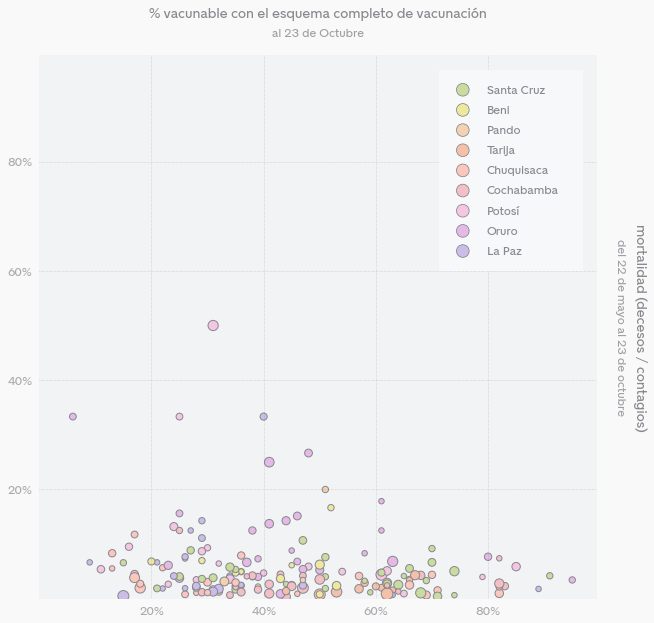

In [531]:
vacunas_mortalidad(v2, '2021-05-22', '2021-10-23', ['% vacunable con el esquema completo de vacunación', 'al 23 de Octubre'])

En la gráfica, los colores representan departamentos y el tamaño de cada punto refleja el número relativo de decesos por covid-19 en el municipio. Sólo incluyo municipios que registraron al menos una muerte en este periodo. En condiciones más ideales la comparación sería entre la mortalidad durante un periodo de tiempo posterior al corte de vacunación. Por el momento no tenemos estos datos, pero es muy probable que sí los tengamos en los próximos meses. 

## Determinantes de vacunación

Qué afecta el nivel de inoculación en una población municipal? Al igual que en el ejercicio anterior, no contamos con datos para identificar relaciones claras de causalidad. Sin embargo, es posible estimar correlaciones y filtrar características municipales que podríamos usar en estudios futuros. Estimo los coeficientes de correlación entre los últimos datos de aplicación de primeras dosis (27 de Noviembre) y los componentes de los Objetivos de Desarrollo Sostenible, y el Índice de Salud Municipal de 2018 (el último año del que tengo datos). Observo, entre coeficientes estadísticamente significativos, que las características más relacionadas describen el acceso y calidad de infraestructura y servicios básicos. Ésto me hace pensar que la vacunación está más limitada por el lado de la oferta que la demanda. Poblaciones con más facilidades físicas e institucionales pueden implementar campañas de vacunación más efectivamente. 

In [574]:
def make_correlaciones(serie, dataframe):

    correlaciones = {}
    for col in dataframe.columns:
        dfi = dataframe[dataframe[col].notna()][col]
        common = list(set(dfi.index).intersection(set(serie.index)))
        coeficiente, pvalue = stats.pearsonr(dfi.loc[common], serie.loc[common])
        correlaciones[col] = {'coeficiente': coeficiente, 'pvalue': pvalue}
    cor_df = pd.DataFrame(correlaciones).T
    cor_df['pvalue < .005'] = cor_df.pvalue < .005
    return cor_df.sort_values('coeficiente', ascending=False)

def get_sdsn(normalizado=False, componentes=True):
    
    if normalizado:
        filename = 'data/sdsn_indices.csv'
    else:
        filename = 'data/sdsn.csv'
    
    sdsn = pd.read_csv(filename, index_col='Código')    
    sdsn = sdsn[[col for col in sdsn.columns[2:] if 'Unnamed' not in col]]
    sdsn = sdsn.replace('.', '')
    coltypes = pd.Series({col:sdsn[col].dtype for col in sdsn.columns})
    for col in coltypes[coltypes == object].index.tolist():
        sdsn[col] = pd.to_numeric(sdsn[col].apply(lambda x: x.replace(',', '') if type(x) == str else x))
    if componentes and not normalizado:
        return sdsn[[col for col in sdsn.columns if col in pd.read_csv('data/sdsn_indices.csv').columns.tolist()]]
    else:
        return sdsn

def plot_correlaciones(correlaciones):
    lincolor = '#88888f'
    dfi = correlaciones[correlaciones['pvalue < .005']].sort_values('coeficiente', ascending=False).coeficiente
    f, ax = plt.subplots(1,1,figsize=(10,20))
    ax.scatter(dfi, dfi.index, color='#ebc08d', zorder=2, edgecolor=lincolor, s=80)
    ax.grid(axis='x', zorder=1)
    ax.grid(axis='y', zorder=1, alpha=.9)
    ax.tick_params(labelcolor=lincolor, labeltop=True)
    ax.set_ylim(len(dfi) - .5, -.5)
    ax.axvline(x=0, linewidth=.8, color=lincolor)
    for text, x in zip(['relacion positiva', 'relación negativa'], [.75, .25]):
        ax.annotate(text, xy=(x, 1.04), xycoords='axes fraction', color=lincolor, ha='center', va='bottom', fontsize=15)

In [581]:
sdsn = get_sdsn()
ism = pd.read_csv('data/ism.csv')
ism = ism[ism.year == 2018].set_index('cod_ine')[ism.columns[5:]]

cor_sdsn = make_correlaciones(v1['2021-11-27'], sdsn)
cor_ism = make_correlaciones(v1['2021-11-27'], ism)

correlaciones = pd.concat([cor_sdsn, cor_ism])

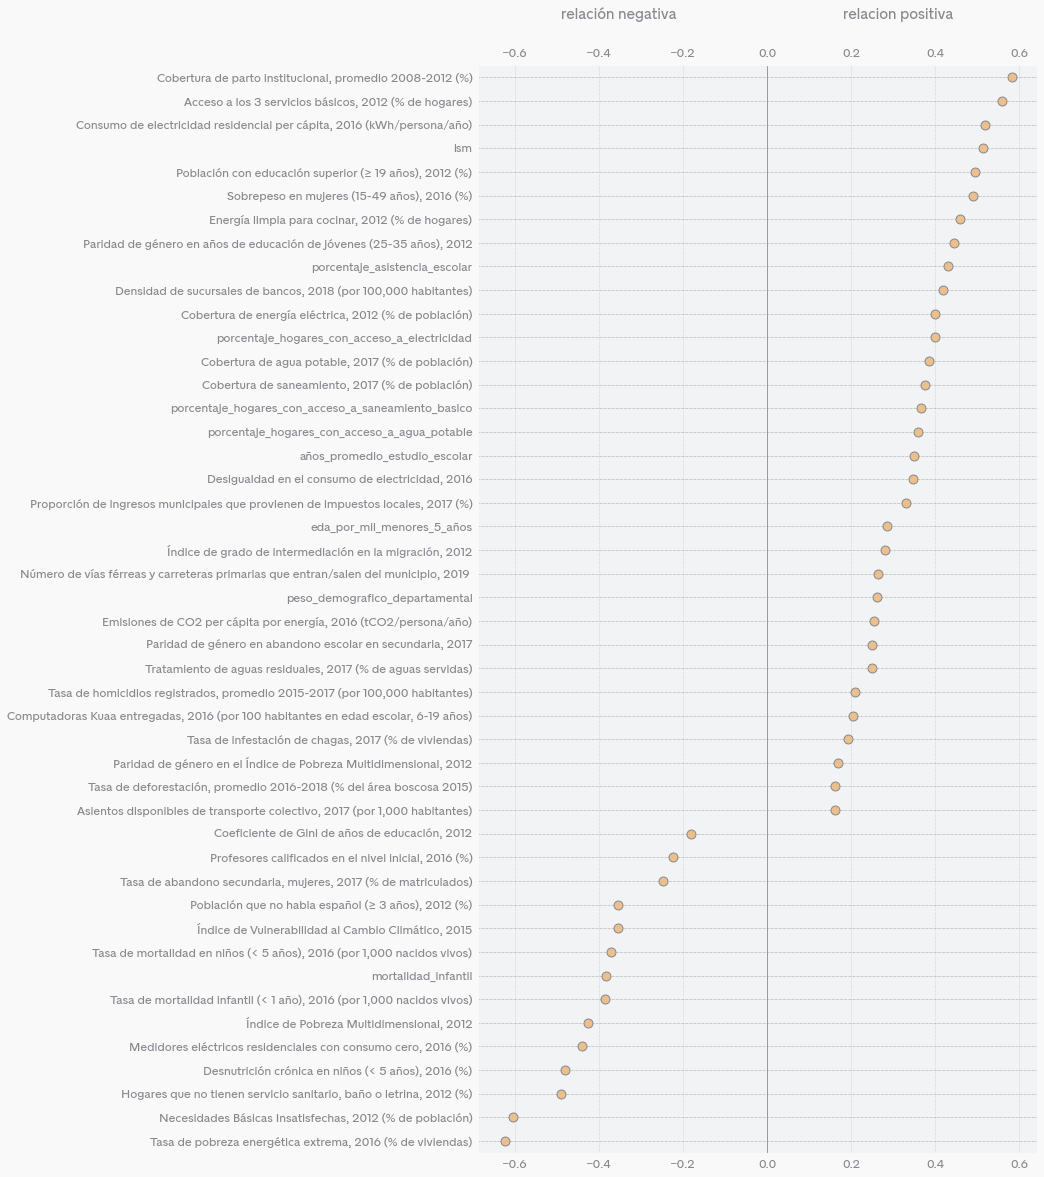

In [582]:
plot_correlaciones(correlaciones)

Seguramente, estas características tienen un efecto sobre la mortalidad por covid-19 que en las condiciones actuales no puedo separar. Queda pendiente indagar en estas relaciones con mejores diseños empíricos y datos.